This notebook showcases how to run the Vensim hydrogen_model in python. It shows a basic examples of reading/loading the model and then sets up relevant dictionaries to easily extract results from model runs.

Next, the notebook goes into how to load new input data in the model/change base assumptions. This enables sensitivity analyses and scenario runs.

Some general visualizations are also included to show how this might be done.

#### Load relevant packages

In [11]:
import pysd
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from IPython.parallel import Client
from time import time
from tqdm import tqdm

#### Load the model

In [207]:
cwd = os.getcwd()
model_name = "hydrogen_model"
model_short_path = "vensim_models/" + model_name

model_loaded = False # Set to True if the model is loaded from a Python file # Saves some time when reloading an unchanged version of the model

start = time()
if model_loaded: # Load the model from the Python file
    model_file = os.path.join(cwd, model_short_path + ".py")
    model = pysd.load(model_file)
else: # Read the model from the Vensim mdl file
    model_file = os.path.join(cwd, model_short_path + ".mdl")
    model = pysd.read_vensim(model_file, split_views = True)

print("Model loaded in {} seconds".format(np.round(time()-start,3)))

Model loaded in 14.254 seconds


#### Setup/modify model

In [67]:
# Example
stocks_of_interest = ["TOTAL GREEN HYDROGEN DEMAND", "Green H2 cost", "TOTAL SUBSIDIES"]

##### Creating lists of sectors

In [68]:
# Define the sectors of the model
steel_sector = ["Coal BF BOF", "Coal BF BOF CCS", "HDRI EAF"]
hvc_sector = ["Fossil naphtha", "Bio naphtha", "Synthetic naphtha"]
meoh_sector = ["Grey MeOH", "Blue MeOH", "BioMeOH", "eMeOH"]
fertilizer_sector = ["Grey NH3", "Blue NH3", "Green NH3"]
temp_sector = ["NG NM", "Blue NG NM", "Biogas NM", "H2 NM"]
refining_sector = ["Grey refinery", "Blue refinery", "Green refinery"]
industry_sectors = steel_sector + hvc_sector + meoh_sector + fertilizer_sector + temp_sector + refining_sector

int_aviation_sector = ["Jetfuel consumption", "Syn kerosene consumption", "Bio kerosene consumption"]
dom_aviation_sector = ["Jetfuel consumption dom", "Syn kerosene consumption dom", "Bio kerosene consumption dom"]
int_shipping_sector = ["HFO shipping consumption", "NH3 shipping consumption", "MeOH shipping consumption"]
dom_shipping_sector = ["Domestic HFO shipping consumption", "Domestic battery shipping consumption", "Domestic MeOH shipping consumption", "Domestic H2 shipping consumption"]
ld_road_transport_sector = ["LD Fossil consumption", "LD BEV consumption", "LD FCEV consumption"]
hd_road_transport_sector = ["HD Fossil consumption", "HD BEV consumption", "HD FCEV consumption"]
transport_sectors = int_aviation_sector + dom_aviation_sector + int_shipping_sector + dom_shipping_sector + ld_road_transport_sector + hd_road_transport_sector

sectors = industry_sectors + transport_sectors

##### Creating dictionaries

In [81]:
# Define the dictionary of sectors, include a key for each sector which defines the unit used in the sector
industry_sector_dict = {"steel": {"unit": "MT", "stocks" : steel_sector, "h2 demand" : "steel hydrogen demand", "emissions" : "steel emissions", "subsidy": "steel subsidy"},
                        "naphtha": {"unit": "MT", "stocks" : hvc_sector, "h2 demand" : "naphtha hydrogen demand", "emissions" : "naphtha emissions", "biomass": "naphtha biomass demand", "subsidy": "naphtha subsidy"},
                        "MeOH": {"unit": "MT", "stocks" : meoh_sector, "h2 demand" : "MeOH hydrogen demand", "emissions" : "MeOH emissions", "biomass": "MeOH biomass demand", "subsidy": "MeOH subsidy"},
                        "fertilizer": {"unit": "MT", "stocks" : fertilizer_sector, "h2 demand" : "fertilizer hydrogen demand", "emissions" : "fertilizer emissions", "subsidy": "fertilizer subsidy"},
                        "high temperature": {"unit": "GWh", "stocks" : temp_sector, "h2 demand" : "high temperature hydrogen demand", "emissions" : "high temperature emissions", "biomass": "high temperature biomass demand", "subsidy": "high temperature subsidy"},
                        "refining": {"unit": "MT", "stocks" : refining_sector, "h2 demand" : "refinery hydrogen demand", "emissions" : "refinery emissions", "subsidy": "refinery subsidy"}}

transport_sector_dict = {"int_aviation": {"unit": "GWh", "stocks" : int_aviation_sector, "h2 demand" : "international aviation hydrogen demand", "emissions" : "international aviation emissions", "biomass": "international aviation biomass demand", "subsidy": "international aviation subsidy"},
                        "dom_aviation": {"unit": "GWh", "stocks" : dom_aviation_sector, "h2 demand" : "domestic aviation hydrogen demand", "emissions" : "domestic aviation emissions", "biomass": "domestic aviation biomass demand", "subsidy": "domestic aviation subsidy"},
                        "int_shipping": {"unit": "GWh", "stocks" : int_shipping_sector, "h2 demand" : "international shipping hydrogen demand", "emissions" : "international shipping emissions", "biomass": "international shipping biomass demand", "subsidy": "international shipping subsidy"},
                        "dom_shipping": {"unit": "GWh", "stocks" : dom_shipping_sector, "h2 demand" : "domestic shipping hydrogen demand", "emissions" : "domestic shipping emissions", "biomass": "domestic shipping biomass demand", "subsidy": "domestic shipping subsidy"},
                        "ld_road_transport": {"unit": "GWh", "stocks" : ld_road_transport_sector, "h2 demand" : "light duty hydrogen demand", "emissions" : "light duty emissions", "subsidy": "light duty subsidy"},
                        "hd_road_transport": {"unit": "GWh", "stocks" : hd_road_transport_sector, "h2 demand" : "heavy duty hydrogen demand", "emissions" : "heavy duty emissions", "subsidy": "heavy duty subsidy"}}

sector_dict = {"industry": industry_sector_dict, "transport": transport_sector_dict}

In [82]:
hydrogen_demands = {"power" : "power hydrogen demand"}
subsidies = {"power" : "power subsidy"}
biomass_demands = {}
emissions = {}

for main_sector in sector_dict.keys():
    for i, (sub_sector, sub_dict) in enumerate(sector_dict[main_sector].items()):
        hydrogen_demands[sub_sector] = sub_dict["h2 demand"]
        subsidies[sub_sector] = sub_dict["subsidy"]
        emissions[sub_sector] = sub_dict["emissions"]
        if "biomass" in sub_dict.keys():
            biomass_demands[sub_sector] = sub_dict["biomass"]

#### Run the model (and save the results)


In [70]:
runs_demand = []
runs_price = []
runs_subsidy = []

subsidies = [0, 0.5, 1, 1.5, 2, 2.5, 3]

for subsidy in tqdm(subsidies, desc="Running model with different subsidies"):
    model.set_components({"Green H2 subsidy size": subsidy})
    run = model.run(return_columns=stocks_of_interest)
    runs_demand.append(run[stocks_of_interest[0]])
    runs_price.append(run[stocks_of_interest[1]])
    runs_subsidy.append(run[stocks_of_interest[2]].iloc[-1])

Running model with different subsidies:   0%|          | 0/7 [00:00<?, ?it/s]

Running model with different subsidies: 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


In [208]:
run = model.run(progress=True)
# Save the model results in a csv file (8 MB file size)
run.to_csv("results\\model_results.csv")
run["TOTAL GREEN HYDROGEN DEMAND"].to_csv("results\\total_green_hydrogen_demand.csv")

ETA:  --:--:-- [----------------------------------------------------------]  0%
ETA:   0:00:15 [----------------------------------------------------------]  0%
ETA:   0:00:17 [----------------------------------------------------------]  1%
ETA:   0:00:15 [#---------------------------------------------------------]  2%
ETA:   0:00:14 [#---------------------------------------------------------]  2%
ETA:   0:00:14 [#---------------------------------------------------------]  3%
ETA:   0:00:14 [##--------------------------------------------------------]  3%
ETA:   0:00:15 [##--------------------------------------------------------]  4%
ETA:   0:00:14 [###-------------------------------------------------------]  5%
ETA:   0:00:14 [###-------------------------------------------------------]  5%
ETA:   0:00:14 [###-------------------------------------------------------]  6%
ETA:   0:00:14 [####------------------------------------------------------]  7%
ETA:   0:00:14 [####--------------------

#### Plot the results

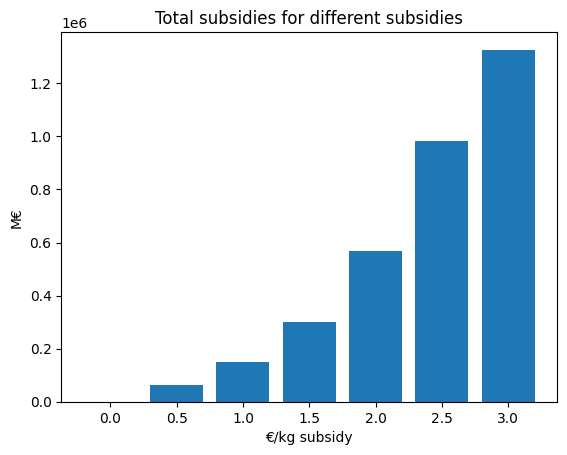

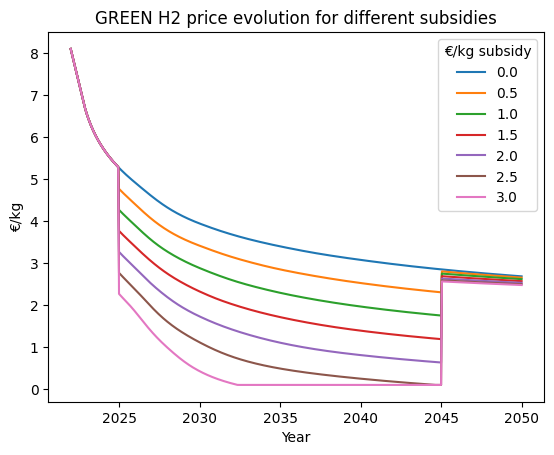

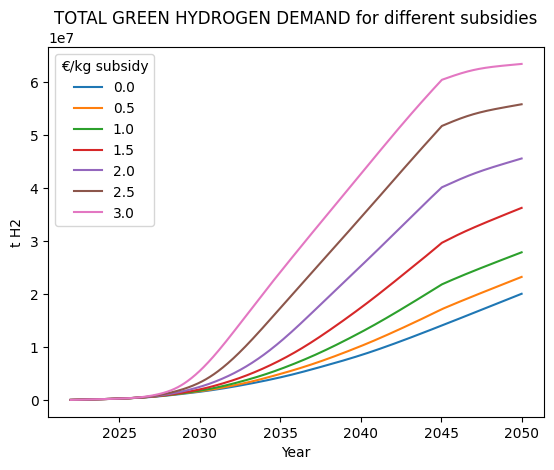

In [71]:
# Plot the total subsidy values in a bar plot
fig, ax = plt.subplots()
plt.bar(subsidies, runs_subsidy, width=0.4)
plt.xticks(subsidies)
plt.title("Total subsidies for different subsidies")
plt.xlabel("€/kg subsidy")
plt.ylabel("M€")
plt.show()

fig, ax = plt.subplots()
df = pd.DataFrame(runs_price).T
df.columns = subsidies
df.index = run.index
df.plot(ax=ax, title="GREEN H2 price evolution for different subsidies")
ax.set_xlabel("Year")
ax.set_ylabel("€/kg")
ax.legend(title="€/kg subsidy")
plt.show()

# Plot the results
fig, ax = plt.subplots()
df = pd.DataFrame(runs_demand).T
df.columns = subsidies
df.index = run.index
df.plot(ax=ax, title="TOTAL GREEN HYDROGEN DEMAND for different subsidies")
ax.set_xlabel("Year")
ax.set_ylabel("t H2")
ax.legend(title="€/kg subsidy")
plt.show()

#### Example of steel sector visualization

In [72]:
# Focusing on the steel industry
stocks_of_interest = ["Coal BF BOF", "Green H2 cost", "Coal BF BOF CCS", "HDRI EAF", "industry TWh", "trans TWh", "power TWh", "H2 DEMAND in TWh"]
model.set_components({"Green H2 subsidy size": 2.0})
run = model.run(return_columns=stocks_of_interest)

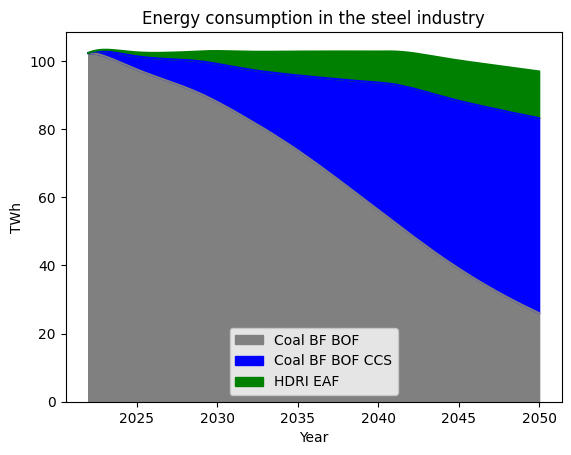

In [73]:
# Create a stacked area plot for the energy consumption from Coal BF BOF, Coal BF BOF CCS, HDRI EAF
fig, ax = plt.subplots()
df = run[["Coal BF BOF", "Coal BF BOF CCS", "HDRI EAF"]]
df.index = run.index
df.plot.area(ax=ax, title="Steel production in the steel industry", color=["gray", "blue", "green"])
ax.set_xlabel("Year")
ax.set_ylabel("MT steel")
plt.show() 

#### Loading all sectors - visualizing all

In [190]:
stocks_of_interest = sectors
sens_models["base"].set_components({"Green H2 subsidy size": 1.5})
run = sens_models["base"].run()

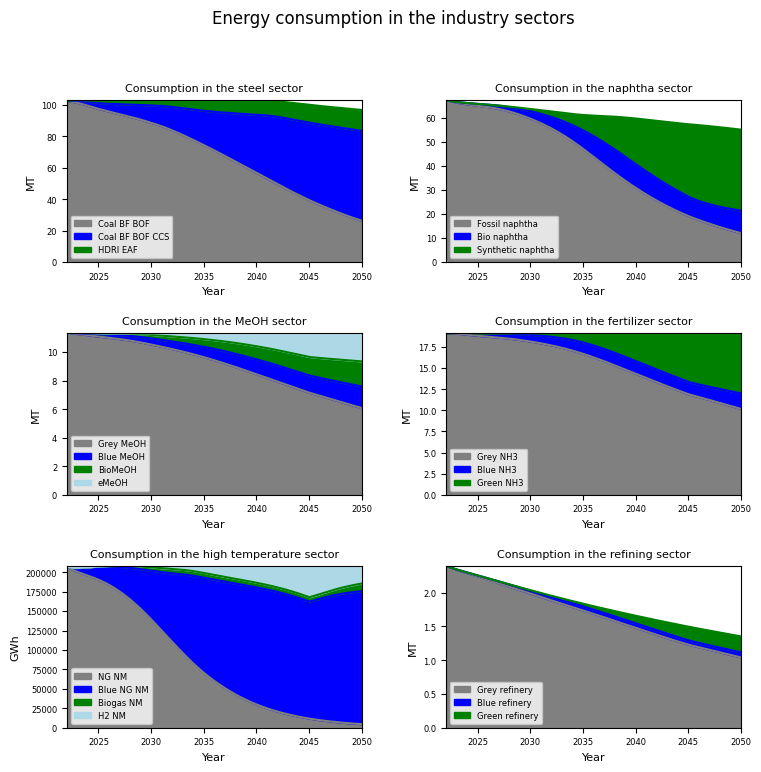

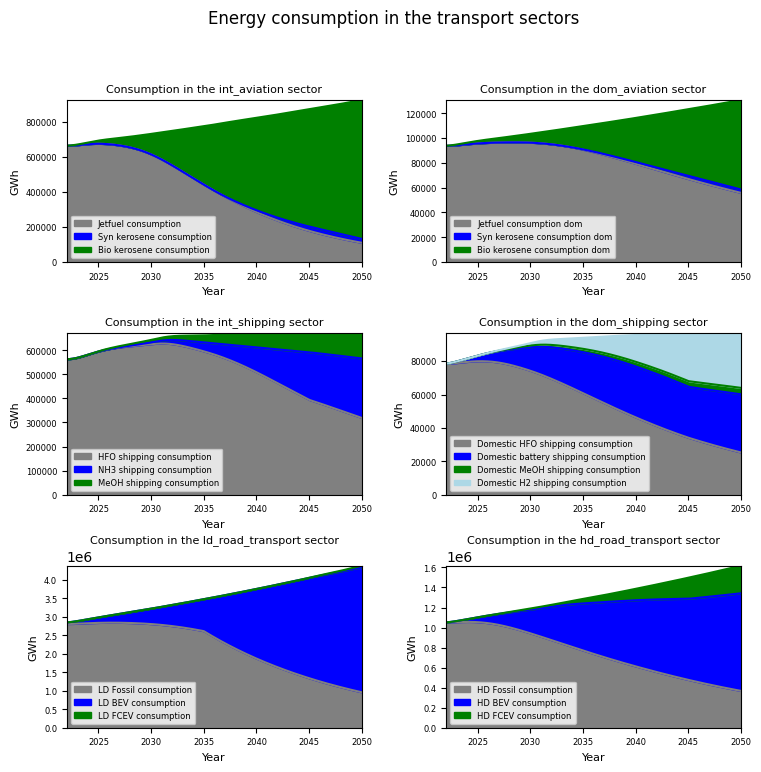

In [191]:
# Visualize the energy consumption in the different sectors using stacked area plots.
# Do this in two separate grid plots. One for industry and one for transport. Use the dictionary sector_dict to get the sectors for each category.
for main_sector in sector_dict.keys():
    fig, axs = plt.subplots(3, 2, figsize=(8, 8))
    fig.suptitle("Energy consumption in the " + main_sector + " sectors")
    fig.tight_layout(pad=3.0)  # Add padding between subplots
    for i, (sub_sector, sub_dict) in enumerate(sector_dict[main_sector].items()):
        df = run[sub_dict["stocks"]]
        df.index = run.index
        df.plot.area(ax=axs[i//2, i%2], color=["gray", "blue", "green", "lightblue"])
        axs[i//2, i%2].title.set_text("Consumption in the " + sub_sector + " sector")
        axs[i//2, i%2].title.set_fontsize(8)
        axs[i//2, i%2].set_xlabel("Year")
        axs[i//2, i%2].set_ylabel(sub_dict["unit"])
        # Reduce the font size of the axis labels
        axs[i//2, i%2].xaxis.label.set_fontsize(8)
        axs[i//2, i%2].yaxis.label.set_fontsize(8)
        # Reduce the size of the tick labels
        axs[i//2, i%2].tick_params(axis='both', which='major', labelsize=6)
        # Reduce the size of the legend
        axs[i//2, i%2].legend(loc='lower left', fontsize=6)
        
        axs[i//2, i%2].autoscale(enable=True, axis='both', tight=True)  # Adjust the axis limits to fit the data

    plt.show()

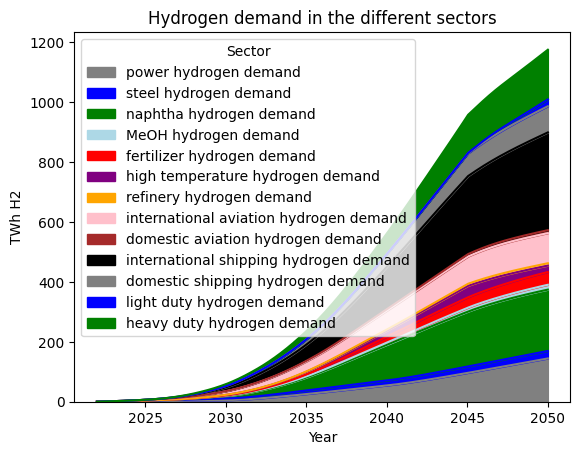

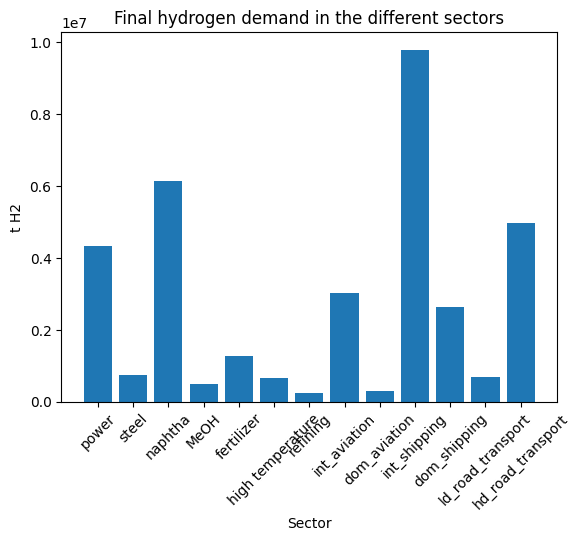

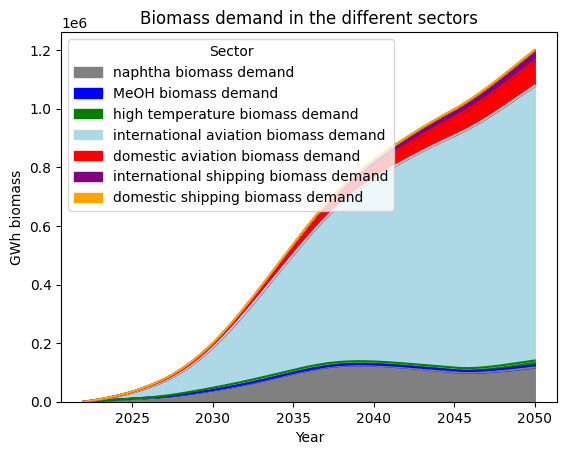

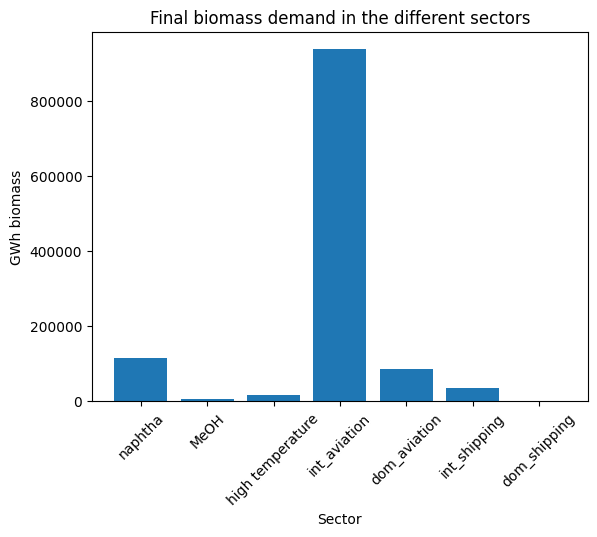

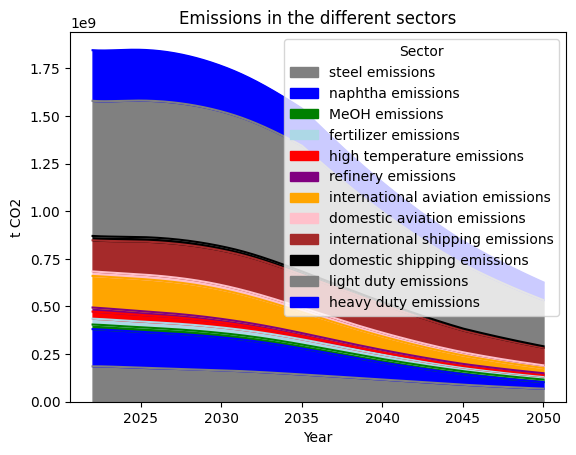

In [192]:
# Visualize the hydrogen demand in the sectors using a stacked area plot.
stocks_of_interest = list(hydrogen_demands.values())
df = run[stocks_of_interest]*33.33/1e6
df.index = run.index
df.plot.area(title="Hydrogen demand in the different sectors", color=["gray", "blue", "green", "lightblue", "red", "purple", "orange", "pink", "brown", "black"])
plt.xlabel("Year")
plt.ylabel("TWh H2")
plt.legend(title="Sector")
plt.show()

# Visualize the total hydrogen demand in the different sectors using a bar plot.
fig, ax = plt.subplots()
plt.bar(hydrogen_demands.keys(), run[stocks_of_interest].iloc[-1])
plt.title("Final hydrogen demand in the different sectors")
plt.xlabel("Sector")
plt.ylabel("t H2")
plt.xticks(rotation=45)
plt.show()

# Visualize the biomass demand in the sectors using a stacked area plot.
stocks_of_interest = list(biomass_demands.values())
df = run[stocks_of_interest]
df.index = run.index
df.plot.area(title="Biomass demand in the different sectors", color=["gray", "blue", "green", "lightblue", "red", "purple", "orange", "pink", "brown", "black"])
plt.xlabel("Year")
plt.ylabel("GWh biomass")
plt.legend(title="Sector")
plt.show()

# Visualize the total biomass demand in the different sectors using a bar plot.
fig, ax = plt.subplots()
plt.bar(biomass_demands.keys(), run[stocks_of_interest].iloc[-1])
plt.title("Final biomass demand in the different sectors")
plt.xlabel("Sector")
plt.ylabel("GWh biomass")
plt.xticks(rotation=45)
plt.show()

# Visualize the emissions in the sectors using a stacked area plot.
stocks_of_interest = list(emissions.values())
df = run[stocks_of_interest]
df.index = run.index
df.plot.area(title="Emissions in the different sectors", color=["gray", "blue", "green", "lightblue", "red", "purple", "orange", "pink", "brown", "black"])
plt.xlabel("Year")
plt.ylabel("t CO2")
plt.legend(title="Sector")
plt.show()


### Try importing new data/other data - change this to enable sensitivity analysis

#### Load new data into the model (does not change the original vensim file)

In [163]:
from python_scripts.data_loading import data_loading_class # Import the data_loading_class from the data_loading.py file, which enables easy access to data from the different data sources

### ------- Load new data ------- ###
dl = data_loading_class()
# All data is loaded with function calls to the data_loading_class.
# **kwargs can be used for "sensitivity" : float, which scales the data with a factor

# Fossil fuels:
gas_prices = dl.load_gas_prices()
oil_prices = dl.load_oil_prices()
coal_prices = dl.load_coal_prices()

# Biomass:
woodchip_prices = dl.load_woodchip_prices()
straw_prices = dl.load_straw_prices()
woodpellet_prices = dl.load_woodpellet_prices()

# Electricity:
electricity_prices = dl.load_electricity_prices()

# Carbon taxes:
dl.load_carbon_taxes()
# Carbon taxes can be specified with the "seamaps" argument, which accesses another source of CT forecasts
# Example:
dl.load_carbon_taxes("seamaps")
# The "sensitivity" argument can be used to scale the data
# Example:
dl.load_carbon_taxes("seamaps", **{"sensitivity" : 1.1})

2000     55.0
2020     55.0
2021     66.0
2022     77.0
2023     88.0
2024     99.0
2025    110.0
2026    121.0
2027    132.0
2028    143.0
2029    154.0
2030    165.0
2031    176.0
2032    187.0
2033    198.0
2034    209.0
2035    220.0
2036    231.0
2037    242.0
2038    253.0
2039    264.0
2040    275.0
2041    286.0
2042    297.0
2043    308.0
2044    319.0
2045    330.0
2046    341.0
2047    352.0
2048    363.0
2049    374.0
2050    385.0
2070    385.0
dtype: float64

#### Comparing model data with loaded data

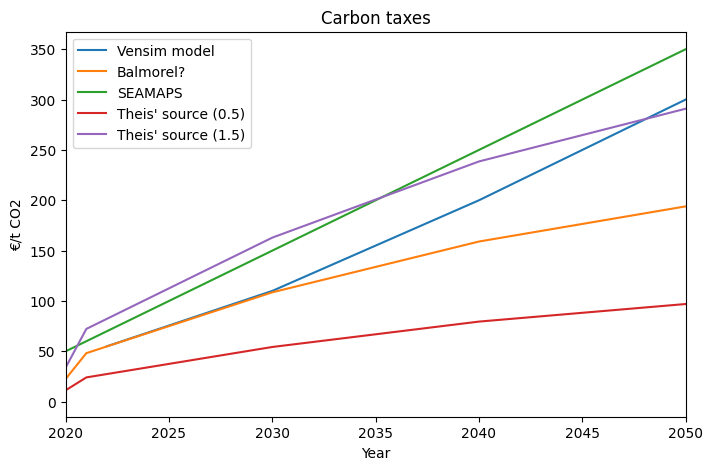

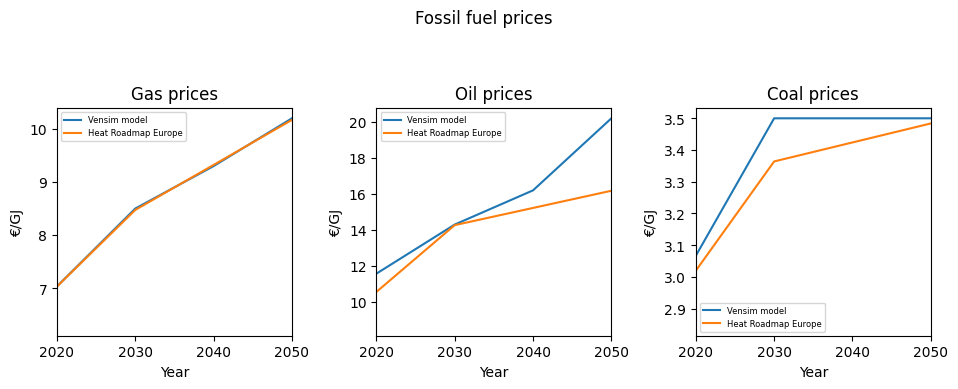

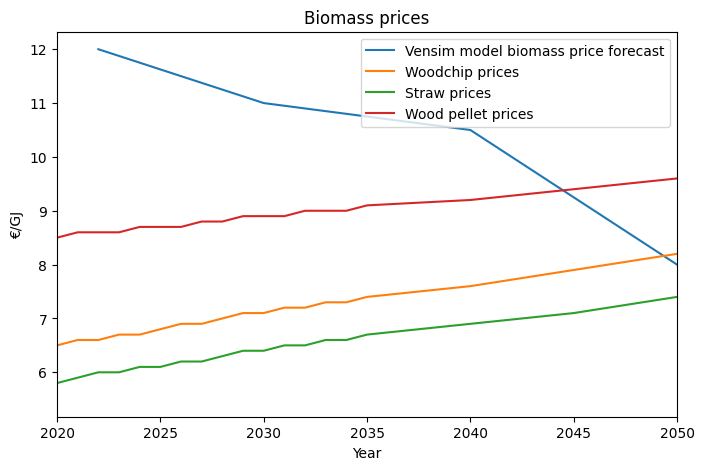

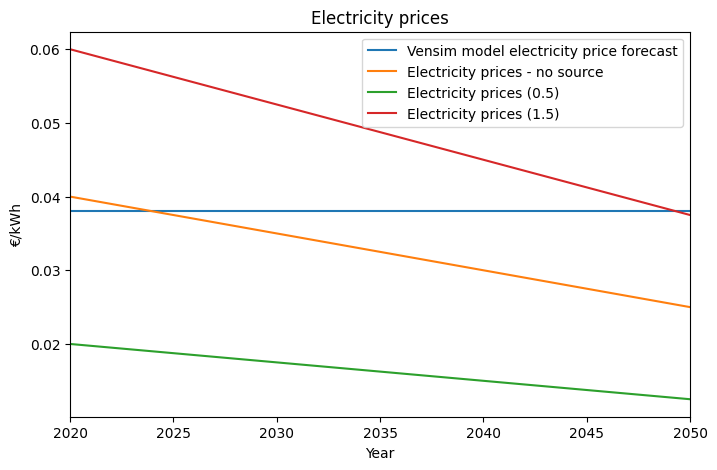

In [176]:
plt.figure(figsize=(8,5))
plt.plot(model.get_series_data('CARBON TAX LOOKUP')['lookup_dim'],model.get_series_data('CARBON TAX LOOKUP'),label="Vensim model")
plt.plot(dl.load_carbon_taxes(), label="Balmorel?")
plt.plot(dl.load_carbon_taxes("seamaps"), label="SEAMAPS")
plt.plot(dl.load_carbon_taxes(**{"sensitivity":0.5}), label="Theis' source (0.5)")
plt.plot(dl.load_carbon_taxes(**{"sensitivity" : 1.5}), label="Theis' source (1.5)")
plt.legend()
plt.title("Carbon taxes")
plt.xlabel("Year")
plt.ylabel("€/t CO2")
plt.xlim(2020, 2050)
plt.show()

# Plot the loaded fossil fuel prices against the Vensim model prices in separate plots for each fuel. Do it in a grid plot.
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle("Fossil fuel prices")
fig.tight_layout(pad=3.0)  # Add padding between subplots
axs[0].plot(model.get_series_data('GAS PRICE LOOKUP')['lookup_dim'], model.get_series_data('GAS PRICE LOOKUP'), label="Vensim model")
axs[0].plot(gas_prices, label="Heat Roadmap Europe")
axs[0].set_title("Gas prices")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("€/GJ")
axs[0].set_xlim(2020, 2050)
axs[0].legend(fontsize=6)

axs[1].plot(model.get_series_data('OIL PRICE LOOKUP')['lookup_dim'], model.get_series_data('OIL PRICE LOOKUP'), label="Vensim model")
axs[1].plot(oil_prices, label="Heat Roadmap Europe")
axs[1].set_title("Oil prices")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("€/GJ")
axs[1].set_xlim(2020, 2050)
axs[1].legend(fontsize=6)

axs[2].plot(model.get_series_data('COAL PRICE LOOKUP')['lookup_dim'], model.get_series_data('COAL PRICE LOOKUP'), label="Vensim model")
axs[2].plot(coal_prices, label="Heat Roadmap Europe")
axs[2].set_title("Coal prices")
axs[2].set_xlabel("Year")
axs[2].set_ylabel("€/GJ")
axs[2].set_xlim(2020, 2050)
axs[2].legend(fontsize=6)
plt.show()

# Plot the loaded biomass prices against the Vensim model prices in a single plot.
plt.figure(figsize=(8,5))
plt.plot(model.get_series_data('BIOMASS PRICE LOOKUP')['lookup_dim'],model.get_series_data('BIOMASS PRICE LOOKUP'),label="Vensim model biomass price forecast")
plt.plot(woodchip_prices, label="Woodchip prices")
plt.plot(straw_prices, label="Straw prices")
plt.plot(woodpellet_prices, label="Wood pellet prices")
plt.legend()
plt.title("Biomass prices")
plt.xlabel("Year")
plt.ylabel("€/GJ")
plt.xlim(2020, 2050)
plt.show()

# Plot the loaded electricity prices against the Vensim model prices in a single plot.
plt.figure(figsize=(8,5))
plt.plot(model.get_series_data('ELECTRICITY PRICE LOOKUP')['lookup_dim'],model.get_series_data('ELECTRICITY PRICE LOOKUP'),label="Vensim model electricity price forecast")
plt.plot(electricity_prices, label="Electricity prices - no source")
plt.plot(dl.load_electricity_prices(**{"sensitivity":0.5}), label="Electricity prices (0.5)")
plt.plot(dl.load_electricity_prices(**{"sensitivity" : 1.5}), label="Electricity prices (1.5)")
plt.legend()
plt.title("Electricity prices")
plt.xlabel("Year")
plt.ylabel("€/kWh")
plt.xlim(2020, 2050)
plt.show()

### Sensitivity analysis

The presented resource cost assumptions form a basis for sensitivity analyses as these are uncertain.

Another focus of sensitivity, the biomass availability ("biomass availability" in Vensim) is a variable limiting the amount of sustainable biomass available in Europe.

Finally, the hydrogen subsidy scheme is a point of interest. "Green H2 subsidy size" - value is in €/kg.

#### Resource sensitivity

Here the electricity price sensitivity could also be interesting

In [159]:
sens_models = {} # Dictionary to store the sensitivity models
sens_models["base"] = model.copy() # Reload the model to reset the changes made to the model/reload = False if we want to copy the exact same model object

In [96]:
### ------- Load data in model - if the original model should be saved use model.copy() to copy the current version of the  ------- ###
sens_models["base"].set_components({"GAS PRICE LOOKUP": gas_prices,
                                    "OIL PRICE LOOKUP": oil_prices,
                                    "COAL PRICE LOOKUP": coal_prices,
                                    "BIOMASS PRICE LOOKUP": woodchip_prices}) #, "ELECTRICITY PRICE LOOKUP": electricity_prices, "CARBON TAX LOOKUP": dl.load_carbon_taxes()})

#### Subsidy sensitivity

In [ ]:
# New subsidy size:
#model.set_components({"Green H2 subsidy size": 3.0})

# New subsidy time frame:
subsidy_start = 2025
subsidy_length = 10

def new_subsidy_pulse():
    t = model.components.time()
    p = 0
    if t >= subsidy_start and t < subsidy_start + subsidy_length:
        p = 1
    return p

#model.components.pulse_h2_subsidy = new_subsidy_pulse

#### Biomass availability sensitivity

In [193]:
# Base biomass availability size:
print("Base biomass availability: ", np.round(model["biomass availability"] /1000, 2), "TWh")

# Set the value in PJ (base scenario: 18350 PJ)
bio_availability = 18350
model.set_components({"biomass availability": bio_availability / 3.6 * 1000}) # Converted to GWh

Base biomass availability:  5097.22 TWh


### Soft-linking the model and running only a submodel. One or multiple views/modules.

In [232]:
tech_cost_modules = ["domestic_aviation_propulsion_costs",
                     "fossil_fuels_production",
                     "methanol_and_biogas_production",
                     "renewable_kerosene_and_naphtha_production",
                     "road_transport_costs",
                     "steel_production",
                     "shipping_costs",
                     "ammonia_production",
                     ]
general_modules = ["financial_resources_and_hyperparameters",
                   "adoption_categories",
                   "hydrogen_production",
                   "carbon_capture_and_storage",
                   ]

In [233]:
# Load exogenous hydrogen demands
df = pd.read_csv("results\\total_green_hydrogen_demand.csv")
df.columns = ["year", "total_green_hydrogen_demand"]
exog_h2_tot_demands = pd.Series(index=df["year"].values.astype(float), data=df["total_green_hydrogen_demand"].values, dtype=float)

In [237]:
# Select the steel submodel
#model.reload() # Reload the model to reset the changes made to the model (if inplace=True has been used earlier)
steel_submodel = model.select_submodel(modules=["iron_and_steel", "steel_production"]+general_modules,
                                       vars=["steel_subsidy_ytd"],
                                       exogenous_components={
                                            "total_subsidies_ytd": 0,
                                            "total_green_hydrogen_demand": exog_h2_tot_demands},
                                       inplace=False)

c:\Users\s203679\OneDrive - Danmarks Tekniske Universitet\Dokumenter\DTU_Man\h2_system_dynamics\.venv\Lib\site-packages\pysd\py_backend\model.py:1891: UserWarning: Selecting submodel, to run the full model again use model.reload()
  warnings.warn(
c:\Users\s203679\OneDrive - Danmarks Tekniske Universitet\Dokumenter\DTU_Man\h2_system_dynamics\.venv\Lib\site-packages\pysd\py_backend\model.py:1141: UserWarning: Replacing a variable by a constant value.
  warnings.warn("Replacing a variable by a constant value.")
c:\Users\s203679\OneDrive - Danmarks Tekniske Universitet\Dokumenter\DTU_Man\h2_system_dynamics\.venv\Lib\site-packages\pysd\py_backend\model.py:1966: UserWarning: Exogenous components for the following variables are necessary but not given:
	biomass_price_scaler

 Please, set them before running the model using set_components method...
  warnings.warn(


In [240]:
steel_submodel.run()

,FINAL TIME,INITIAL TIME,SAVEPER,TIME STEP,early adopters,early majority,early switch level,inno switch level,innovators,laggards,...,BF Coal emission factor,Coal LHV,Coal to Steel,EL to Steel BF Coal,EL to Steel HDRI,Foundry proxy AF,HDRI CAPEX,HDRI cost,steel subsidy removal,yearly steel subsidy limit
time,,,,,,,,,,,,,,,,,,,,,
2022.00,2050,2022,0.05,0.05,0.1,0.34,0.75,0.45,0.05,0.16,...,1.815,29,0.8,250,5.8,1.0,750.0,1267.228638,0.0,200
2022.05,2050,2022,0.05,0.05,0.1,0.34,0.75,0.45,0.05,0.16,...,1.815,29,0.8,250,5.8,1.0,750.0,1264.089777,0.0,200
2022.10,2050,2022,0.05,0.05,0.1,0.34,0.75,0.45,0.05,0.16,...,1.815,29,0.8,250,5.8,1.0,750.0,1260.939266,0.0,200
2022.15,2050,2022,0.05,0.05,0.1,0.34,0.75,0.45,0.05,0.16,...,1.815,29,0.8,250,5.8,1.0,750.0,1257.777767,0.0,200
2022.20,2050,2022,0.05,0.05,0.1,0.34,0.75,0.45,0.05,0.16,...,1.815,29,0.8,250,5.8,1.0,750.0,1254.605882,0.0,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2049.80,2050,2022,0.05,0.05,0.1,0.34,0.75,0.45,0.05,0.16,...,1.815,29,0.8,250,5.8,1.0,750.0,954.079456,0.0,200
2049.85,2050,2022,0.05,0.05,0.1,0.34,0.75,0.45,0.05,0.16,...,1.815,29,0.8,250,5.8,1.0,750.0,954.025287,0.0,200
2049.90,2050,2022,0.05,0.05,0.1,0.34,0.75,0.45,0.05,0.16,...,1.815,29,0.8,250,5.8,1.0,750.0,953.971154,0.0,200


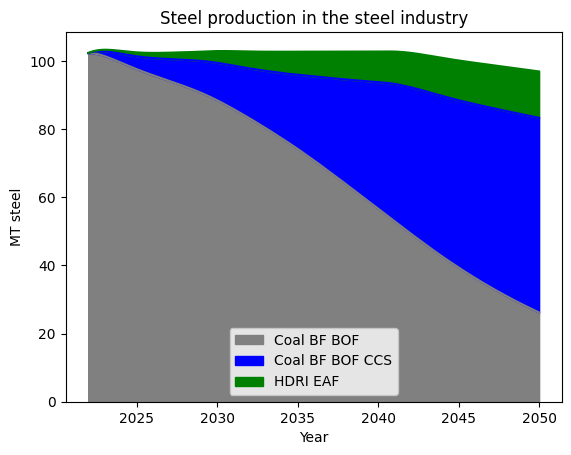

In [239]:
sub_run = steel_submodel.run(return_columns=steel_sector)

# Create a stacked area plot for the energy consumption from Coal BF BOF, Coal BF BOF CCS, HDRI EAF
fig, ax = plt.subplots()
df = sub_run[["Coal BF BOF", "Coal BF BOF CCS", "HDRI EAF"]]
df.index = run.index
df.plot.area(ax=ax, title="Steel production in the steel industry", color=["gray", "blue", "green"])
ax.set_xlabel("Year")
ax.set_ylabel("MT steel")
plt.show() 